In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
from pprint import pprint
import scienceplots
import sys
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - time_window - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,test_obs
DATA_START_DATE = '2000-01-01'
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-12-31'
from pandas import read_csv
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


ModuleNotFoundError: No module named 'feature_engineer'

In [5]:
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
import pandas as pd
DATA_START_DATE = '2000-01-01'
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-12-31'
df_dow = YahooDownloader(start_date = DATA_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
df_hsi = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = HSI_50_TICKER).fetch_data()
df_dax = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DAX_30_TICKER).fetch_data()

df_sp500 = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = SP_500_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ALXN']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[****

$BF.B: possibly delisted; No price data found  (1d 2015-01-01 -> 2024-12-31)


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BHGE']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BLL']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[***************

Shape of DataFrame:  (1102805, 8)


In [7]:
df_dow.to_csv('./data/dow.csv')
df_hsi.to_csv('./data/hsi.csv')
df_dax.to_csv('./data/dax.csv')
df_sp500.to_csv('./data/sp500.csv')

In [2]:

df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
from stable_baselines3.common.callbacks import CheckpointCallback
from datetime import datetime

def train(train_data,test_data,INDICATORS,model_name,model_parameters,iterations,
          save = True,load_model = False,tag='',sortino = False,sharpe=False,pct_fee = 0.001
          ,threshold=None
          ,model_path = None):
    stock_dimension = len(train_data.tic.unique())
    state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
    buy_cost_list = sell_cost_list = [pct_fee] * stock_dimension
    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
        "hmax": 100,
        "initial_amount": 1000000,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "turbulence_threshold" : threshold,
        "sortino_reward": sortino,
        "sharpe_reward": sharpe,
        
    }


    train_environment = StockTradingEnv(df = train_data, **env_kwargs)
    test_environment = StockTradingEnv(df = test_data, **env_kwargs)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                    tensorboard_log = './tensorboard_log_alternative/',
                                    model_kwargs = model_parameters)
    checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./history_alternative/'+tag+'/',
                                                 name_prefix=model_name)
    if not load_model:
        model = agent.train_model(model=model_agent, 
                                    tb_log_name=model_name + '_' + tag,
                                    checkpoint_callback=checkpoint_callback,
                                    total_timesteps=iterations)
    else:
      print('loading model')
      if model_path:
        model = model_agent.load(model_path ,env =train_environment)
      else:
        model = model_agent.load('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' +tag ,env =train_environment)
    if save and not load_model:
        model.save('./data/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    predictions = DRLAgent.DRL_prediction(model, test_environment)
    predictions[0].date = pd.to_datetime(predictions[0].date )
    return {
            'name': model_name,
            'account':predictions[0],
            'actions':predictions[1],
            'state':test_environment.state_memory,
            }


In [4]:
len(df_nasdaq.tic.unique())

90

In [4]:
DATA_START_DATE = '2014-01-01'
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed = fe.preprocess_data(df_nasdaq[df_nasdaq["date"] > TRAIN_START_DATE])
cleaned_data = processed.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features
Stock Dimension: 86, State Space: 259


In [ ]:
ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",None,200_000,False,load_model=True)
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,200_000,False,load_model=True)
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,200_000,False,load_model=True)
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,200_000,False,load_model=True)

In [ ]:
ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",None,200_000,False,load_model=True)
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,200_000,False,load_model=True)
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,200_000,False,load_model=True)
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,200_000,False,load_model=True)
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,200_000,False,load_model=True)

state shape is account value + prices + current holding of stocks   + indicators values for each stock

# Todo : change reward function

In [ ]:

ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",None,100_000,False,load_model=True)
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,100_000,False,load_model=True)
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,100_000,False,load_model=True)
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,100_000,False,load_model=True)
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,100_000,False,load_model=True)



In [ ]:
states = np.array(td3_predictions['state'])
states_prices = states[:,1:len(train_data.tic.unique())+1]
states_shares = states[:,len(train_data.tic.unique())+1 : 2*len(train_data.tic.unique())+1  ]

In [103]:
holdigns = states_shares* states_prices
holdings = pd.DataFrame(holdigns,columns=train_data.tic.unique())


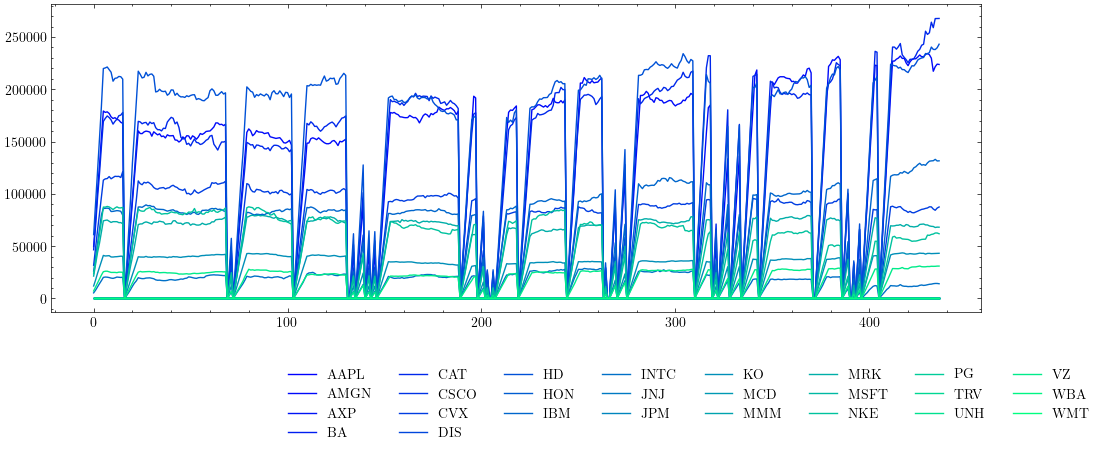

In [ ]:
%matplotlib inline
with plt.style.context('science','ieee'):
    holdings.plot(figsize=(12,4),colormap="winter",).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

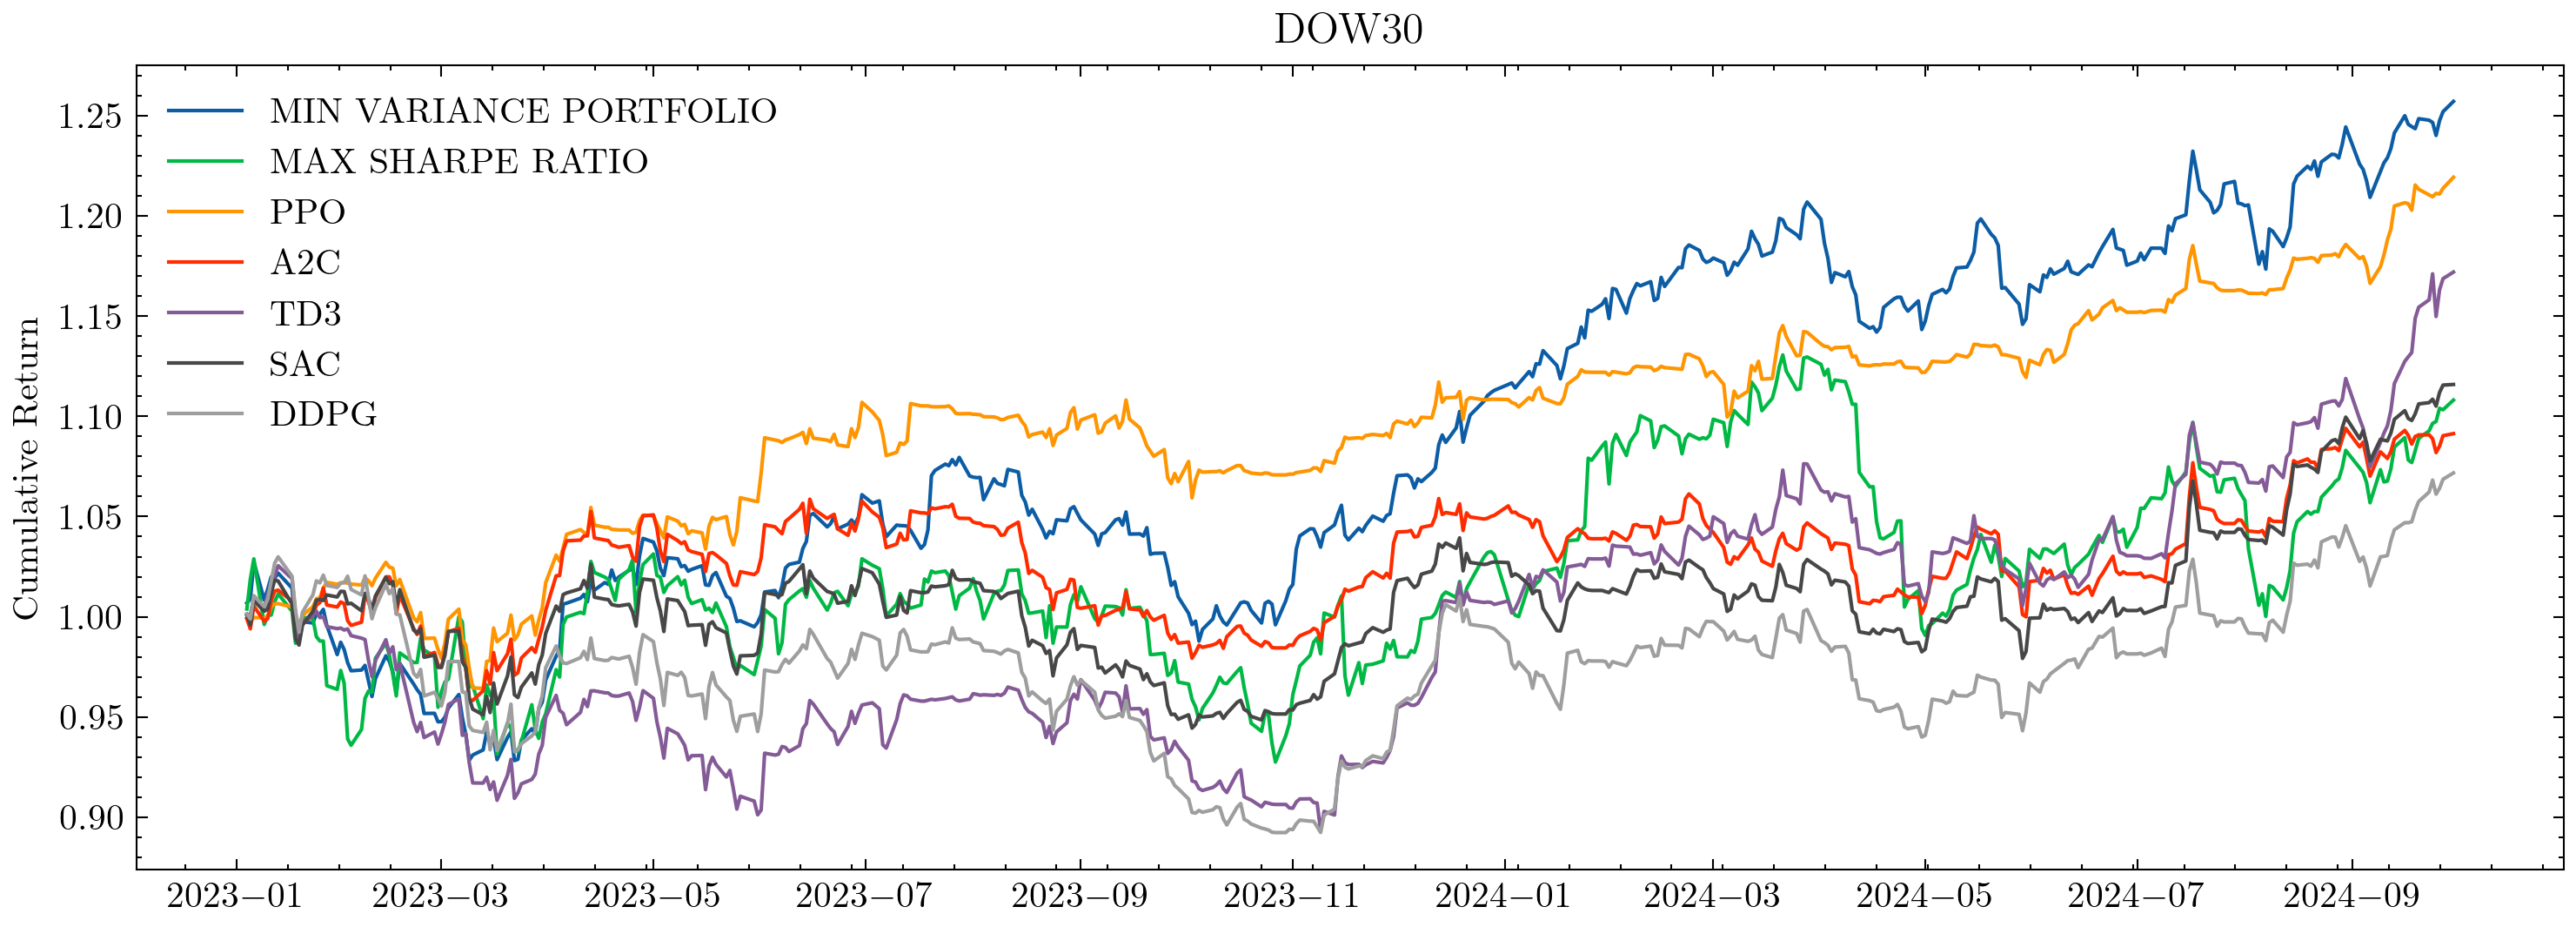

In [ ]:



with plt.style.context('science','ieee'):
    
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(results):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.plot(ppo_predictions['account']['date'],(ppo_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='PPO')
    plt.plot(a2c_predictions['account']['date'],(a2c_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='A2C')
    plt.plot(td3_predictions['account']['date'],(td3_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='TD3')
    plt.plot(sac_predictions['account']['date'],(sac_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='SAC')
    plt.plot(ddpg_predictions['account']['date'],(ddpg_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='DDPG')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('DOW30')
    plt.show()

In [ ]:
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2006-12-30'
TEST_START_DATE = '2007-01-01'
TEST_END_DATE = '2009-12-31'

train_data = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)


In [117]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0003,
    "batch_size": 128,
}

ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",PPO_PARAMS,100_001,tag='recession')
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,100_001,tag='recession')
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,100_001,tag='recession')
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,100_001,tag='recession')
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,100_001,tag='recession')



Stock Dimension: 26, State Space: 79
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 1.76e+03   |
|    ep_rew_mean     | -6.78      |
| time/              |            |
|    fps             | 115        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.26828608 |
-----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.76e+03      |
|    ep_rew_mean          | -8            |
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2             |
|    time_elapsed         | 36            |
|   

In [119]:
results = baseline(processed_dax, INDICATORS, TEST_START_DATE, TEST_END_DATE)

begin_total_asset:50000
end_total_asset:45397.853830802545
Sharpe:  -0.07122663024319065
Test Finished!
episode_return 0.907957076616051
begin_total_asset:1000000
end_total_asset:937659.021342952
Sharpe:  -0.004584509538979365
Test Finished!
episode_return 0.9376590213429521
begin_total_asset:1000000
end_total_asset:937659.021342952
Sharpe:  -0.004584509538979365
Test Finished!
episode_return 0.9376590213429521


In [6]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0003,
    "batch_size": 128,
}

In [ ]:
ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",PPO_PARAMS,10,False,load_model=False,tag='4_dec')
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,10,False,load_model=False,tag='4_dec')
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,10,False,load_model=False,tag='4_dec')
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,10,False,load_model=False,tag='4_dec')
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,10,False,load_model=False,tag='4_dec')



In [11]:
iterations = 50_000
ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",PPO_PARAMS,iterations,True,load_model=False,tag='4_dec',sortino=True)
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='4_dec',sortino=True)
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='4_dec',sortino=True)
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='4_dec',sortino=True)
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='4_dec',sortino=True)



Stock Dimension: 25, State Space: 76
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/              |              |
|    fps             | 13           |
|    iterations      | 1            |
|    time_elapsed    | 152          |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.026787769 |
-------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 13           |
|    iterations           | 2            |
|    time_elapsed         | 305          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0096473675 |
|    clip_fraction        | 0.161        |
|    clip_range           | 0.2          |
|    entropy_los

# NASDAQ

In [106]:
INDICATORS = [
    "close_5_ema",
]
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2006-12-30'
TEST_START_DATE = '2007-01-01'
TEST_END_DATE = '2009-12-31'
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_nasdaq)
processed_dax = processed_dax.copy()
processed_dax = processed_dax.fillna(0)
processed_dax = processed_dax.replace(np.inf,0)
train_data = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)


Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


In [10]:
iterations = 60_000
ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='nasdaq')
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='nasdaq')
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='nasdaq')
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='nasdaq')
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='nasdaq')

Stock Dimension: 32, State Space: 97
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 1.76e+03     |
|    ep_rew_mean     | -0.0772      |
| time/              |              |
|    fps             | 85           |
|    iterations      | 1            |
|    time_elapsed    | 23           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0027542373 |
-------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.76e+03      |
|    ep_rew_mean          | -0.108        |
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 2             |
|    time_elapsed       

In [14]:
res = [ppo_predictions,a2c_predictions,td3_predictions,sac_predictions,ddpg_predictions]

In [15]:
with open('./data/nasdaq_recession_16_12.pkl','wb') as f:
    pickle.dump(res,f)

In [147]:
with open('./data/nasdaq_recession_16_12.pkl','rb') as f:
    res = pickle.load(f)

In [ ]:

cov_df = mvo_data(processed_dax, INDICATORS, TEST_START_DATE, TEST_END_DATE)
mvo_result = mvo(cov_df)


In [63]:
def mvo(data, solver='OSQP', rf=0.02, pct=0.001,objective='min_variance'):
    final_result = []
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf,objective=objective)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = [mvo_min_variance]
    result["name"] = 'Min Variance Portfolio'
    final_result.append(result)
    return final_result
    

In [12]:
mvo_result = mvo(cov_df)

begin_total_asset:50000
end_total_asset:51782.79459653551
Sharpe:  0.16652528240085468
Test Finished!
episode_return 1.0356558919307102


In [6]:
[ppo_predictions,a2c_predictions,td3_predictions,sac_predictions,ddpg_predictions] = res

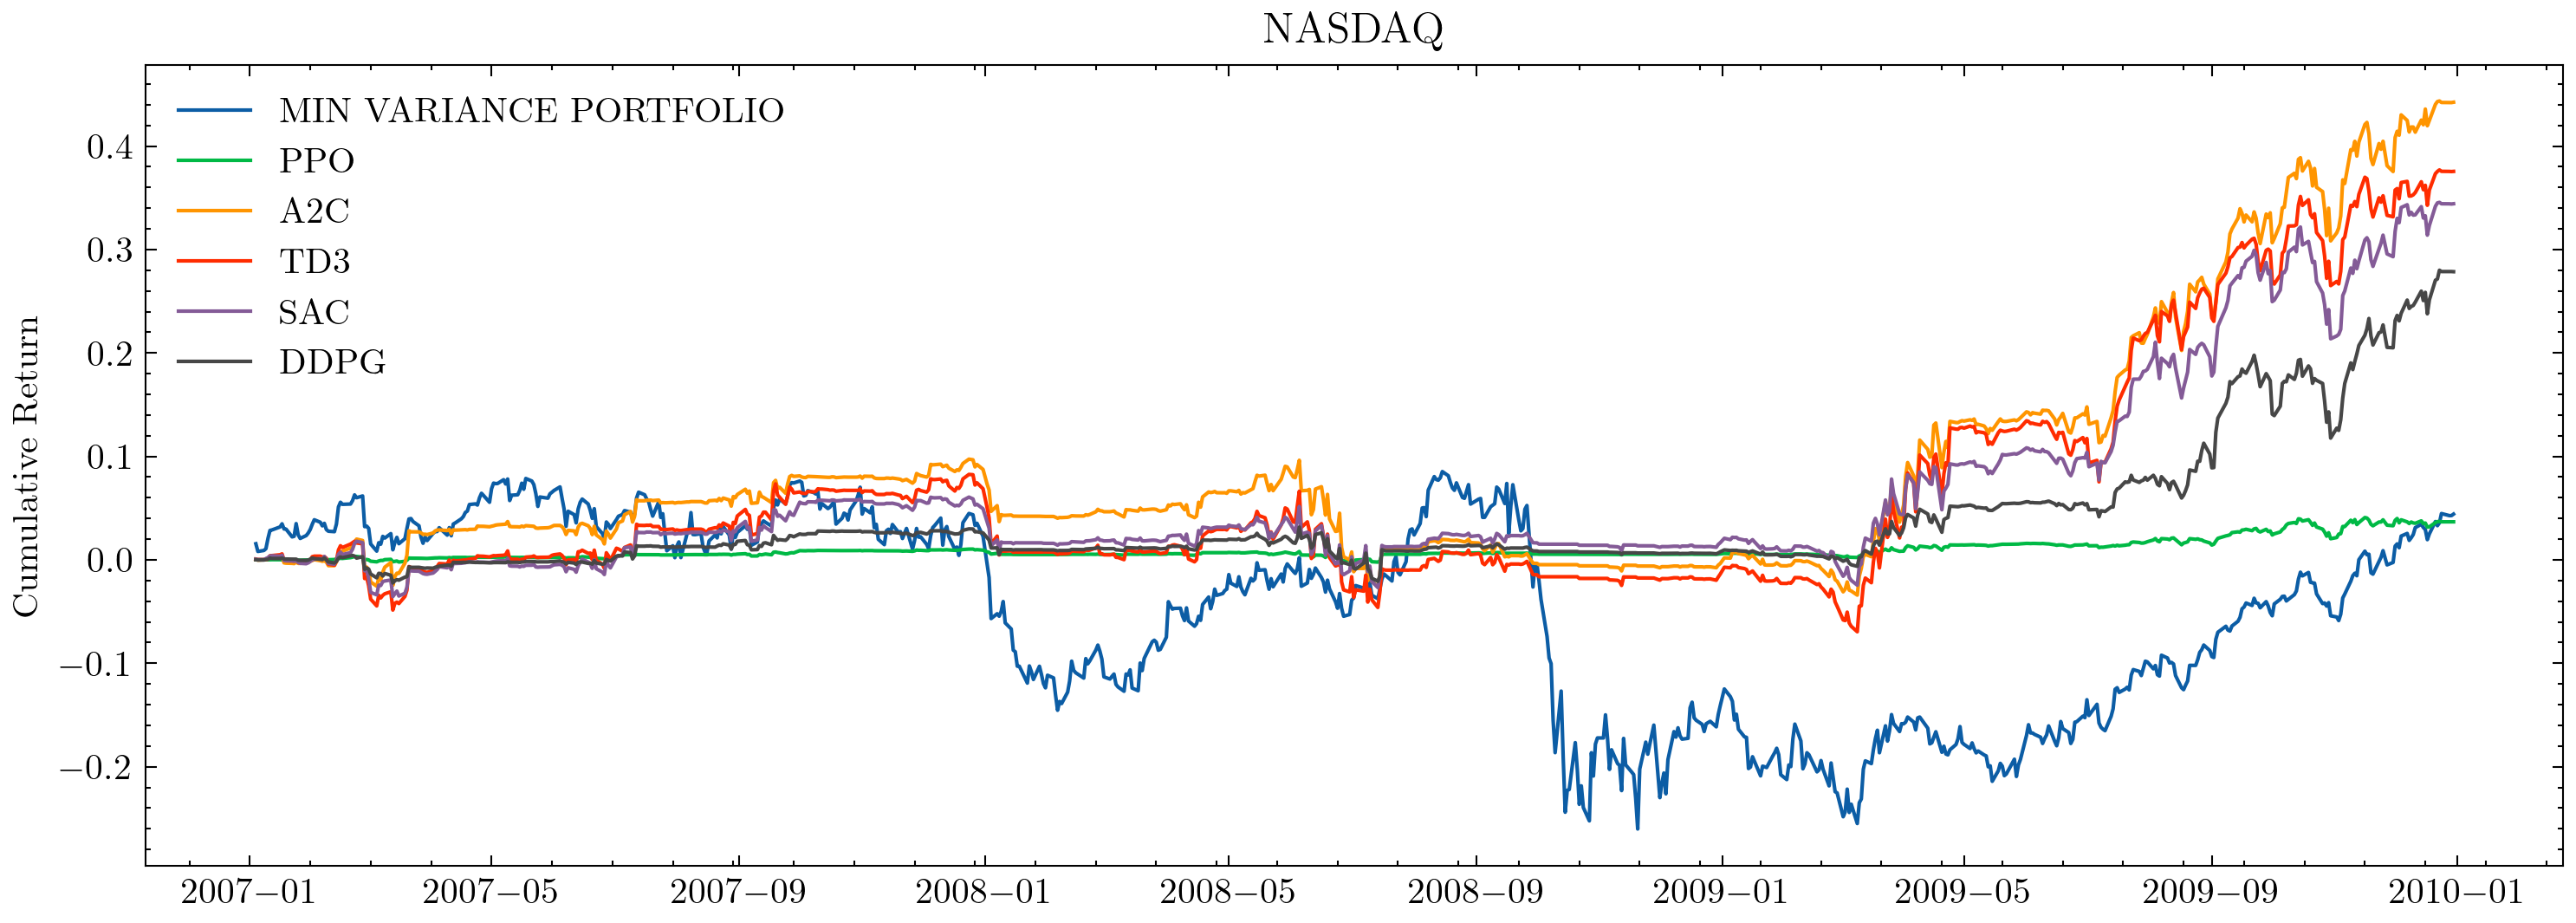

In [22]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(mvo_result):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod() -1,label=str(item['name']).upper())
    plt.plot(ppo_predictions['account']['date'],(ppo_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(a2c_predictions['account']['date'],(a2c_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='A2C')
    plt.plot(td3_predictions['account']['date'],(td3_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='TD3')
    plt.plot(sac_predictions['account']['date'],(sac_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(ddpg_predictions['account']['date'],(ddpg_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='DDPG')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('NASDAQ')
    plt.show()

## SHARPE RATIO

In [ ]:
iterations = 60_000
ppo_predictions_sharpe = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='nasdaq',sharpe=True)
a2c_predictions_sharpe = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='nasdaq',sharpe=True)
td3_predictions_sharpe = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='nasdaq',sharpe=True)
sac_predictions_sharpe = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='nasdaq',sharpe=True)
ddpg_predictions_sharpe = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='nasdaq',sharpe=True)


In [7]:
res = [ppo_predictions_sharpe,a2c_predictions_sharpe,td3_predictions_sharpe,sac_predictions_sharpe,ddpg_predictions_sharpe]

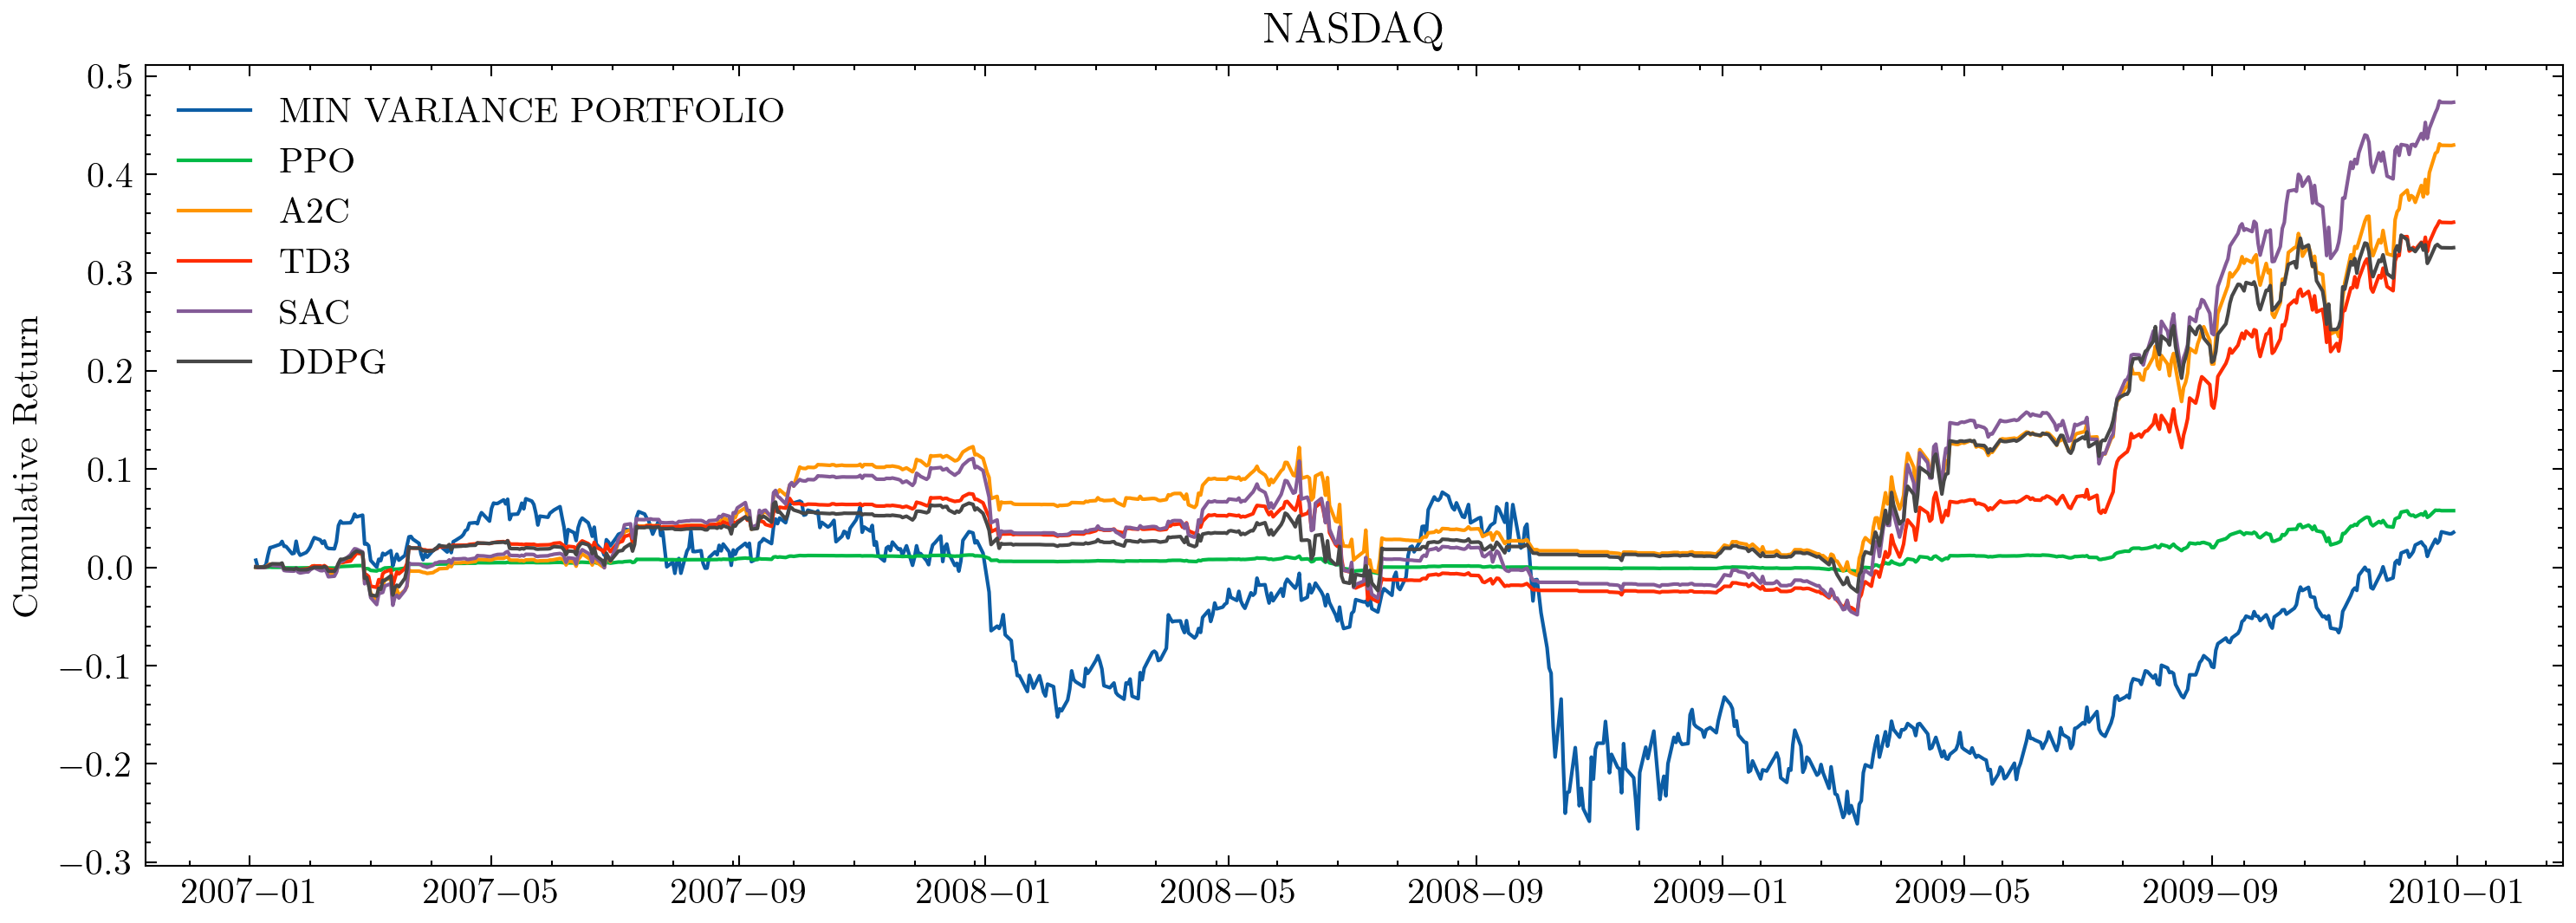

In [13]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(mvo_result):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod() -1,label=str(item['name']).upper())
    plt.plot(ppo_predictions_sharpe['account']['date'],(ppo_predictions_sharpe['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(a2c_predictions_sharpe['account']['date'],(a2c_predictions_sharpe['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='A2C')
    plt.plot(td3_predictions_sharpe['account']['date'],(td3_predictions_sharpe['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='TD3')
    plt.plot(sac_predictions_sharpe['account']['date'],(sac_predictions_sharpe['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(ddpg_predictions_sharpe['account']['date'],(ddpg_predictions_sharpe['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='DDPG')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('NASDAQ')
    plt.show()

In [123]:
sac_predictions['account'].iloc[1:,]

date  account_value
1   2007-01-04   1.000553e+06
2   2007-01-05   9.998170e+05
3   2007-01-08   9.998506e+05
4   2007-01-09   1.000198e+06
5   2007-01-10   1.001248e+06
..         ...            ...
750 2009-12-23   1.474614e+06
751 2009-12-24   1.473139e+06
752 2009-12-28   1.473023e+06
753 2009-12-29   1.473015e+06
754 2009-12-30   1.473333e+06

[754 rows x 2 columns]

In [128]:
sac_predictions['account'].iloc[1:,:]

date  account_value
1   2007-01-04   1.000553e+06
2   2007-01-05   9.998170e+05
3   2007-01-08   9.998506e+05
4   2007-01-09   1.000198e+06
5   2007-01-10   1.001248e+06
..         ...            ...
750 2009-12-23   1.474614e+06
751 2009-12-24   1.473139e+06
752 2009-12-28   1.473023e+06
753 2009-12-29   1.473015e+06
754 2009-12-30   1.473333e+06

[754 rows x 2 columns]

In [145]:
%matplotlib inline
weights_ppo = plot_weights(sac_predictions['state'],train_data)
weights_ppo['date'] = sac_predictions['account'].iloc[:,:].date

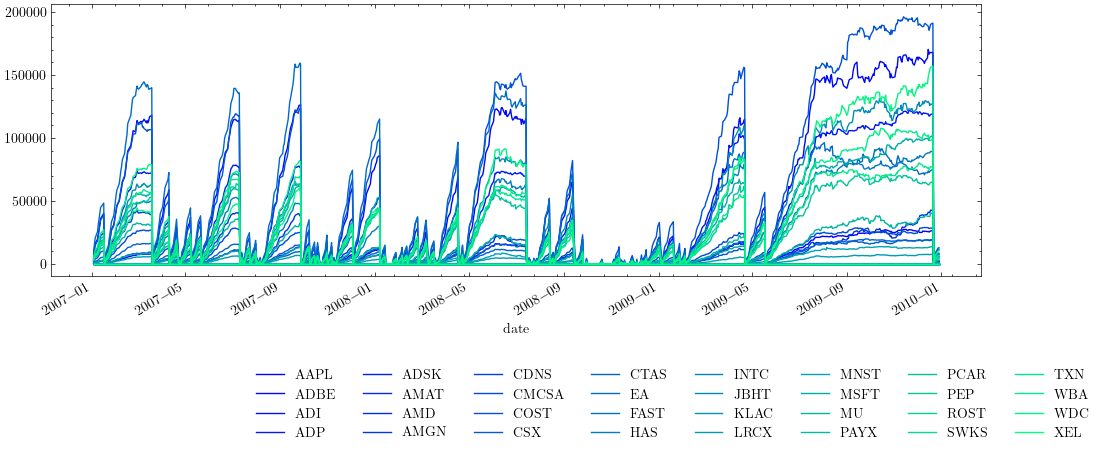

In [146]:
%matplotlib inline
with plt.style.context('science','ieee'):
    weights_ppo.plot(x='date',figsize=(12,4),colormap="winter",).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

# RISK TOLERANCE

In [ ]:
iterations = 60_000
ppo_predictions_risk = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='nasdaq_no_turbulence',threshold=None)
a2c_predictions_risk = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='nasdaq_no_turbulence',threshold=None)
sac_predictions_risk = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='nasdaq_no_turbulence',threshold=None)
ddpg_predictions_risk = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='nasdaq_no_turbulence',threshold=None)


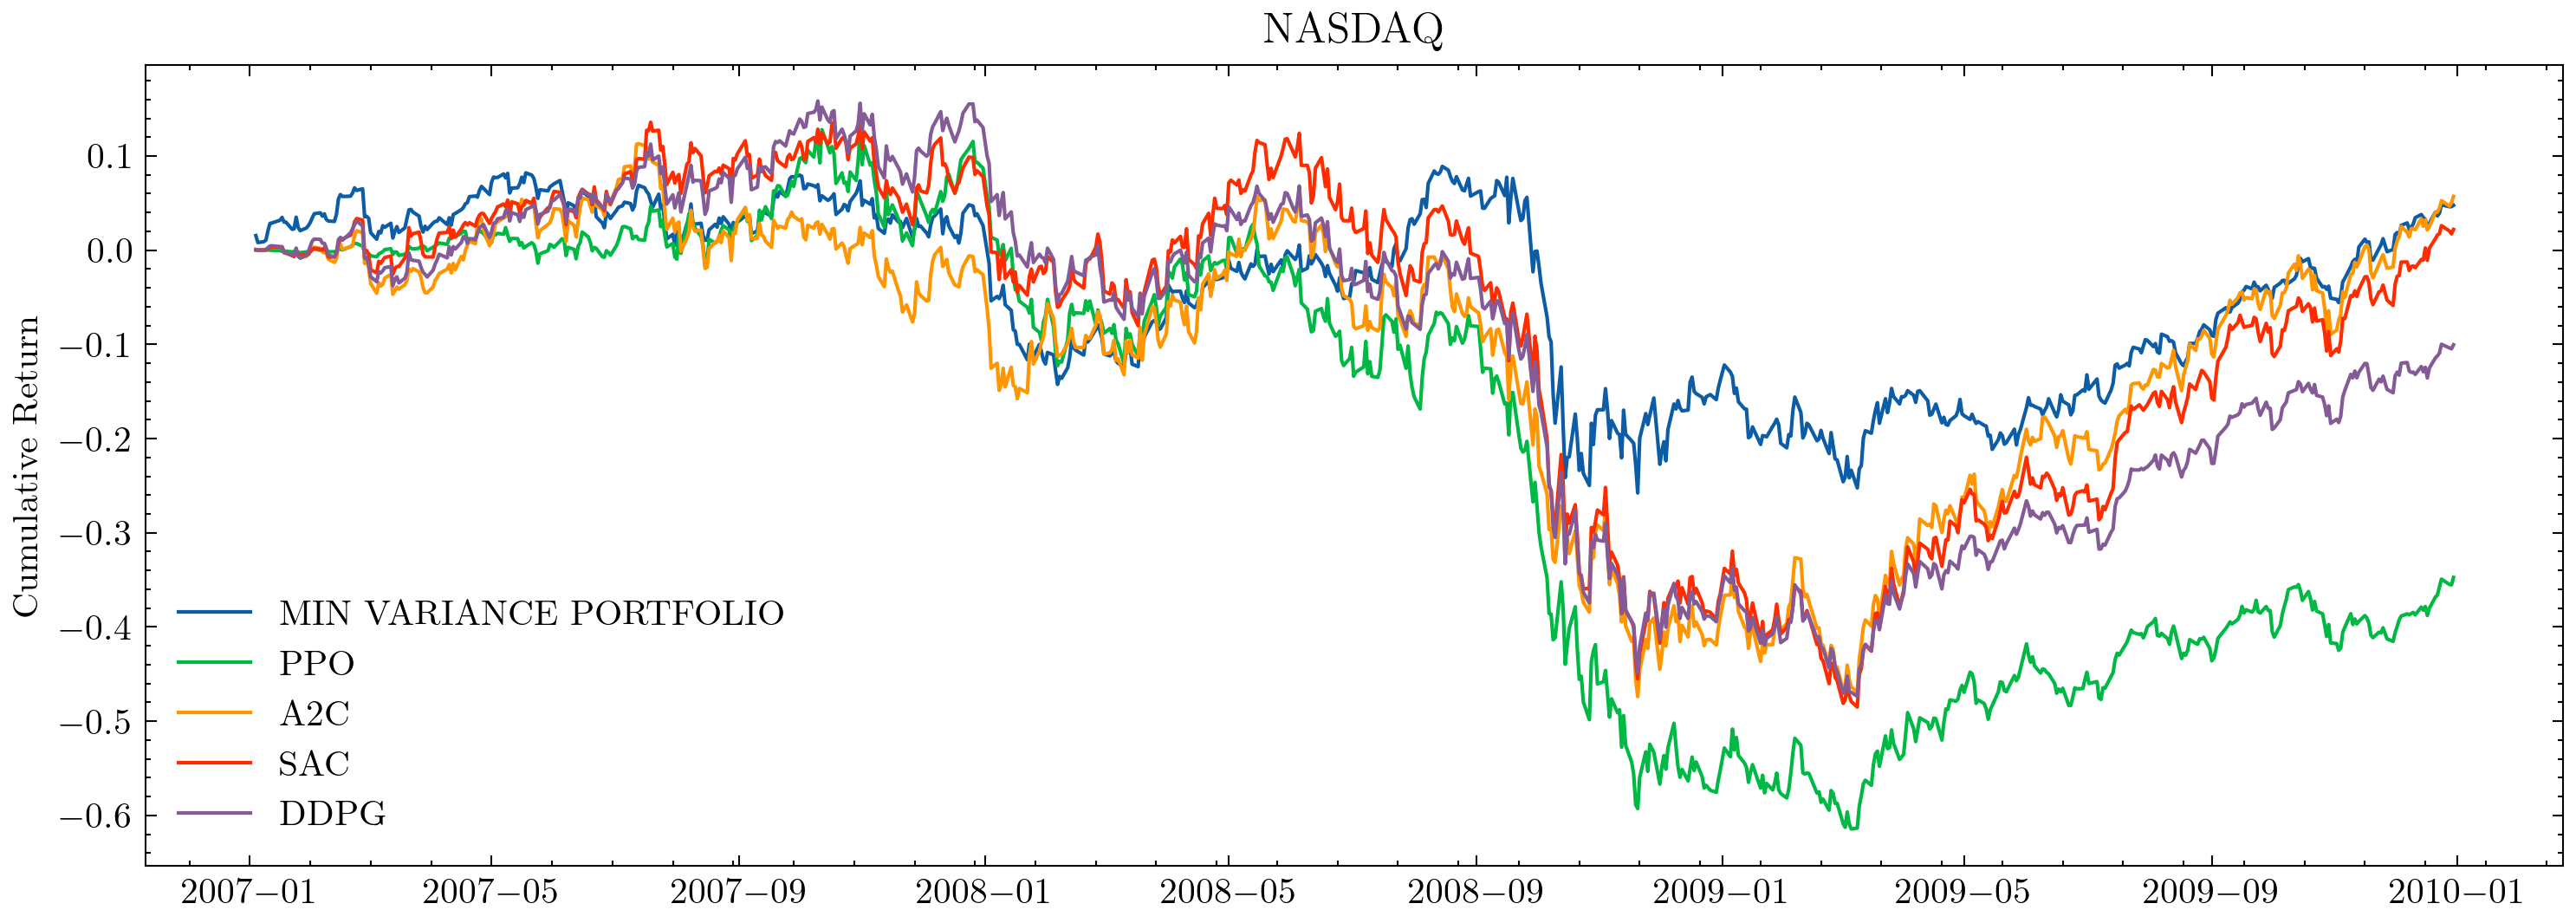

In [22]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(mvo_result):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod() -1,label=str(item['name']).upper())
    plt.plot(ppo_predictions_risk['account']['date'],(ppo_predictions_risk['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(a2c_predictions_risk['account']['date'],(a2c_predictions_risk['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='A2C')
    plt.plot(sac_predictions_risk['account']['date'],(sac_predictions_risk['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(ddpg_predictions_risk['account']['date'],(ddpg_predictions_risk['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='DDPG')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('NASDAQ')
    plt.show()

# TRANSACTION FEE

In [17]:
iterations = 60_000
ppo_predictions_fee = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='nasdaq_no_fee',threshold=None,pct_fee=0.02)
a2c_predictions_fee = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='nasdaq_no_fee',threshold=None,pct_fee=0.02)
sac_predictions_fee = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='nasdaq_no_fee',threshold=None,pct_fee=0.02)
ddpg_predictions_fee = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='nasdaq_no_fee',threshold=None,pct_fee=0.02)


Stock Dimension: 32, State Space: 97
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 1.76e+03    |
|    ep_rew_mean     | -3.77       |
| time/              |             |
|    fps             | 126         |
|    iterations      | 1           |
|    time_elapsed    | 16          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.004913857 |
------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.76e+03     |
|    ep_rew_mean          | -3.56        |
| time/                   |              |
|    fps                  | 121          |
|    iterations           | 2            |
|    time_elapsed         | 33           |


In [19]:
mvo_result = mvo(cov_df,pct=0.02)

begin_total_asset:50000
end_total_asset:52383.77082324541
Sharpe:  0.18313717153238004
Test Finished!
episode_return 1.0476754164649082


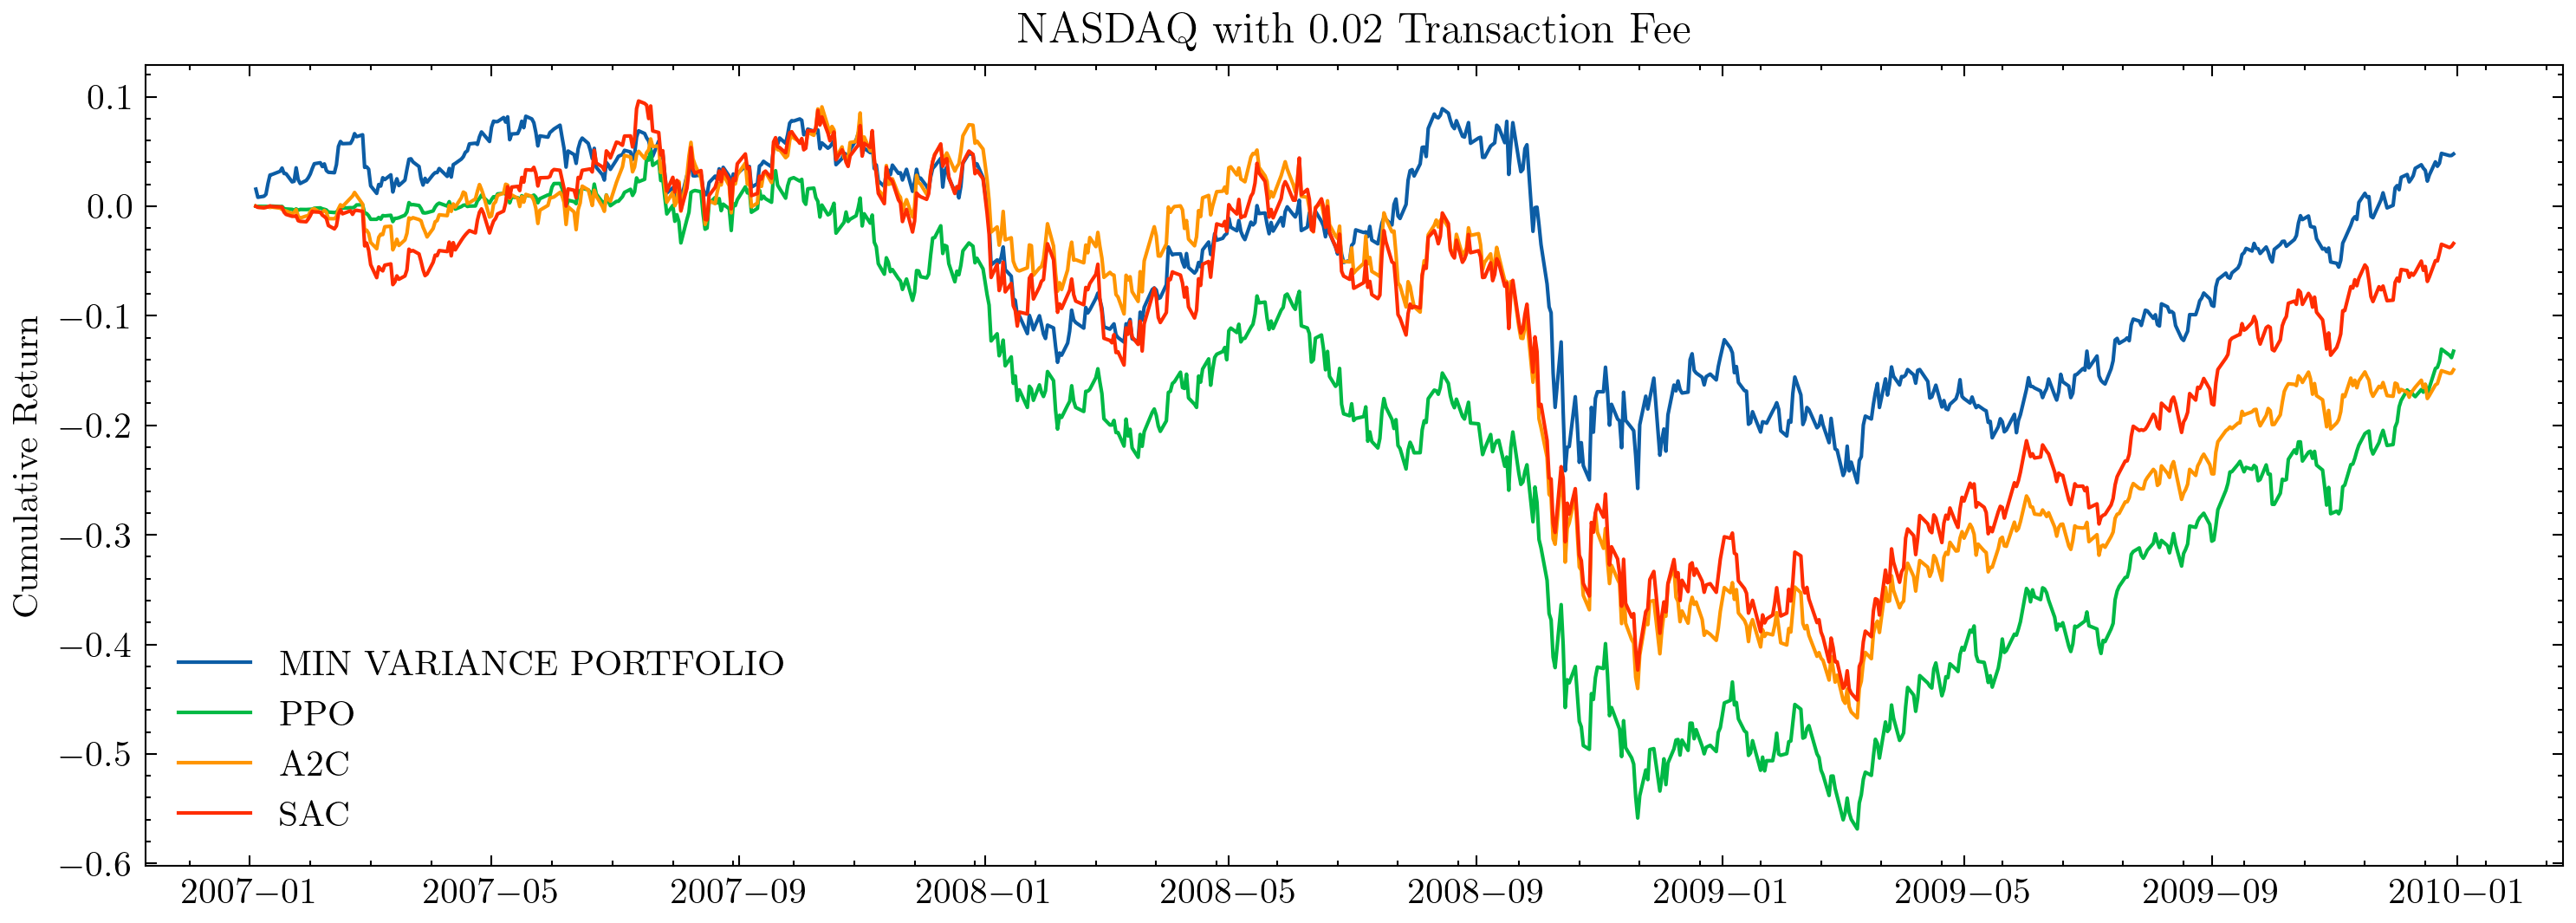

In [23]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(mvo_result):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod() -1,label=str(item['name']).upper())
    plt.plot(ppo_predictions_fee['account']['date'],(ppo_predictions_fee['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(a2c_predictions_fee['account']['date'],(a2c_predictions_fee['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='A2C')
    plt.plot(sac_predictions_fee['account']['date'],(sac_predictions_fee['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('NASDAQ with 0.02 Transaction Fee')
    plt.show()

# DAX

In [3]:
DATA_START_DATE = '2014-01-01'
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed = fe.preprocess_data(df_dax[df_dax["date"] > TRAIN_START_DATE])
cleaned_data = processed.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features
Stock Dimension: 26, State Space: 79


Mahalanobis Distance:

current_temp = current_price - np.mean(filtered_hist_price, axis=0)

temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(current_temp.values.T)


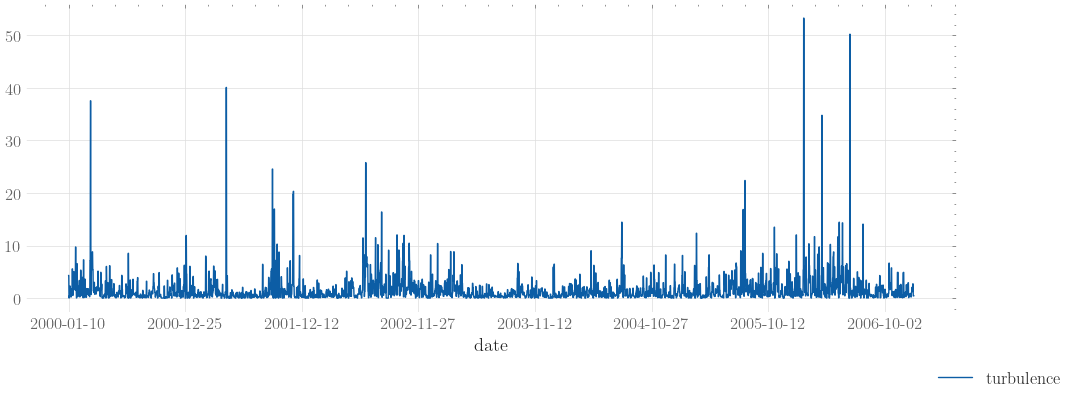

In [48]:
train_data.iloc[10:,].query('turbulence < 70').plot(x='date',y='turbulence',figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))


In [9]:
from utils import mvo,mvo_data
covs = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE)

In [12]:

def mvo(data, solver='OSQP', window=1, rf=0.02, pct=0.001, objective='min_variance'):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": [],
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "window": window

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf, objective=objective, cost=pct)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    return result

In [14]:
min_variance_portfolio = mvo(covs,pct=0.001)


begin_total_asset:50000
end_total_asset:56733.14893038319
Sharpe:  2.087175862021461
Test Finished!
episode_return 1.1346629786076639


In [15]:
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0.001,rf=0)


begin_total_asset:50000
end_total_asset:52411.20741574056
Sharpe:  1.4896181754117797
Test Finished!
episode_return 1.0482241483148111


In [27]:
def buy_and_hold(test_data):
    stock_dimension = len(test_data.tic.unique())

    environment = PortfolioOptimizationEnv(
        test_data,
        initial_amount=50_000,
        comission_fee_pct=0.001,
        time_window=1,
        comission_fee_model='wvm',
        features = ["close","return"],
        normalize_df=None
    )
    terminated = False

    environment.reset()

    while not terminated:
        action = [1/stock_dimension] * stock_dimension
        _, _, terminated, _ = environment.step(
            np.array(action, dtype=np.float32))
    return environment
bh_portfolio = buy_and_hold(test_data)

Episode:1
Initial portfolio value:50000
Final portfolio value: 68311.8515625
Final accumulative portfolio value: 1.36623703125


## log return

In [ ]:
iterations = 200_000
ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='dax_return_reward')
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='dax_return_reward')
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='dax_return_reward')


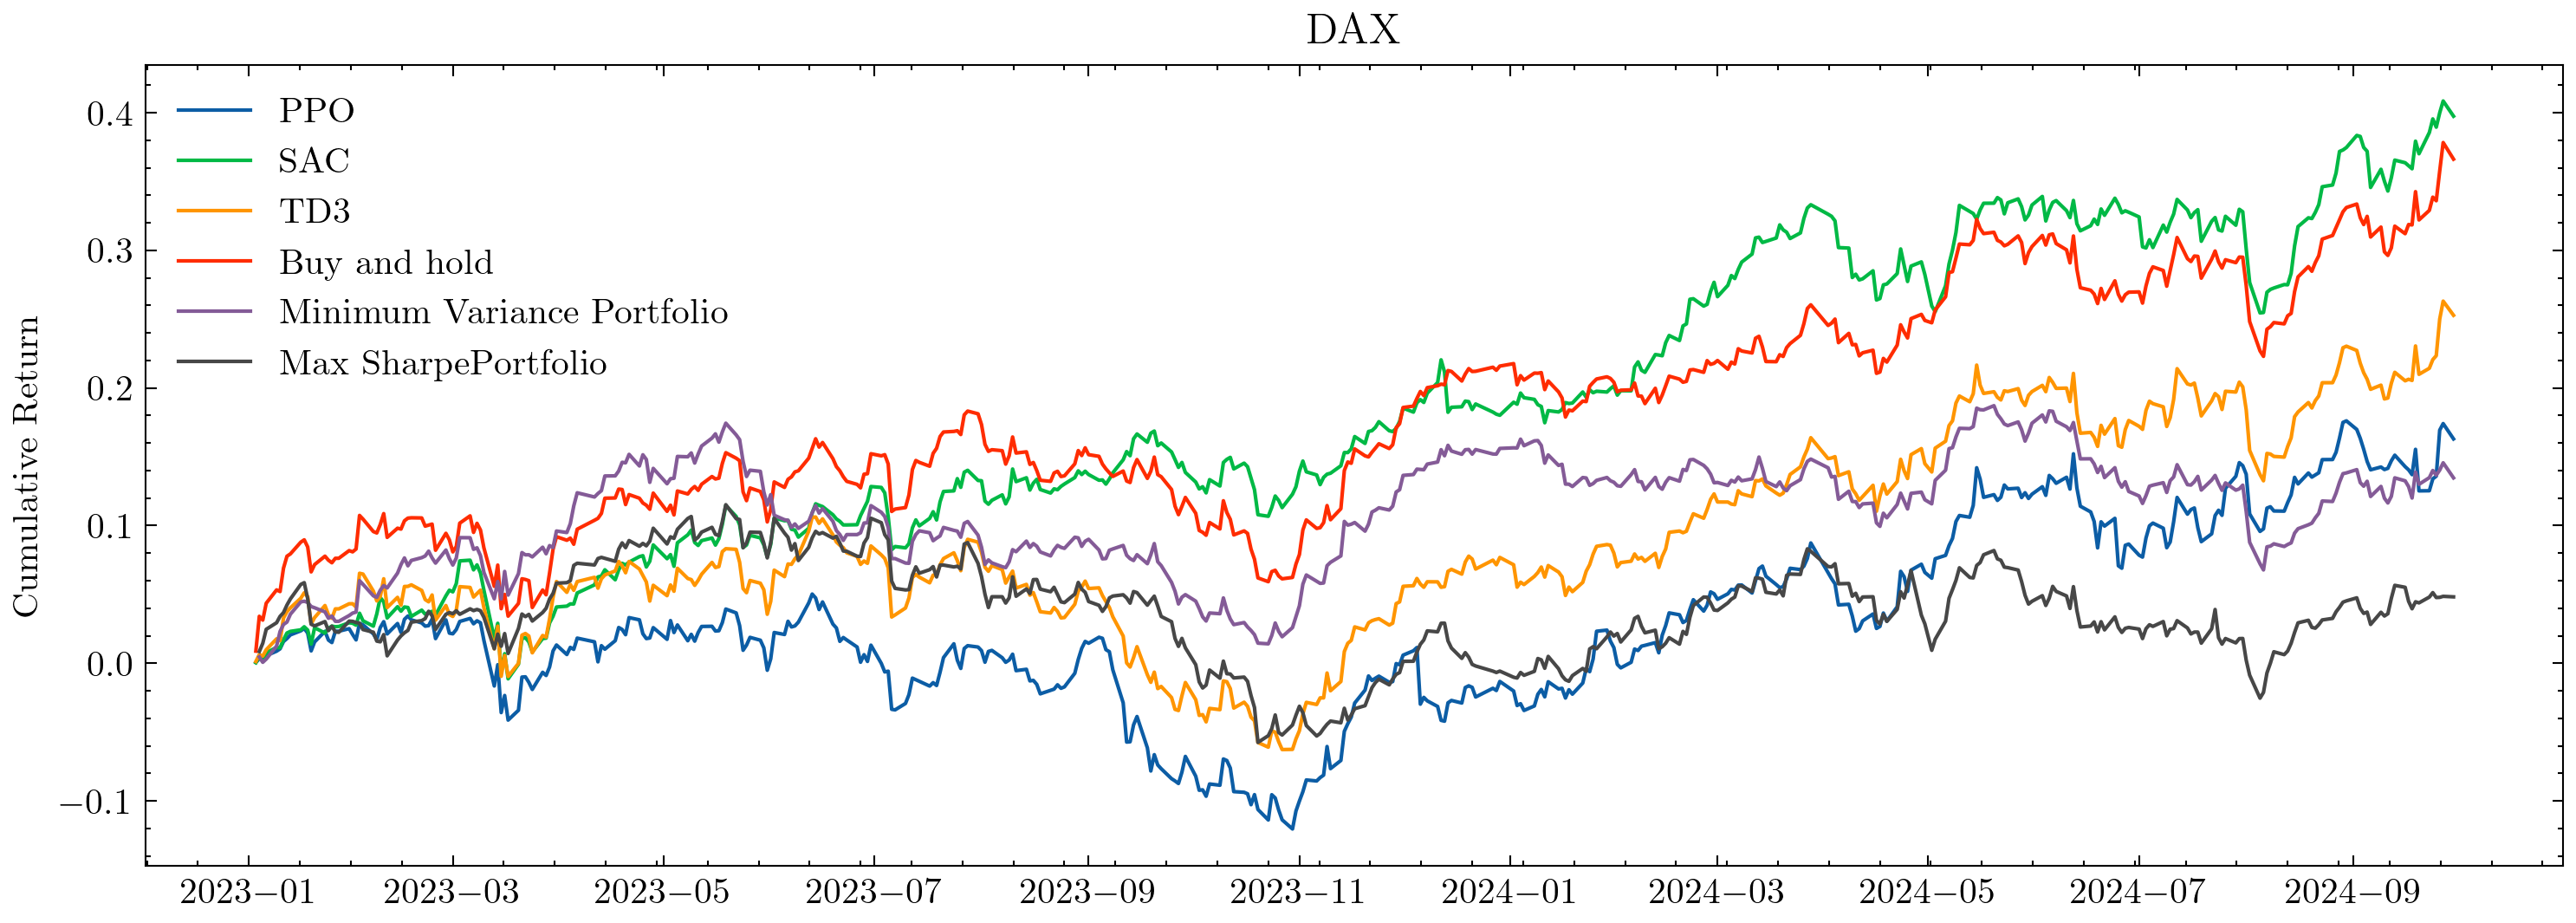

In [31]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(ppo_predictions['account']['date'],(ppo_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(sac_predictions['account']['date'],(sac_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(td3_predictions['account']['date'],(td3_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='TD3')
    plt.plot(bh_portfolio._date_memory,(pd.Series(bh_portfolio._asset_memory["final"]).pct_change() +1).cumprod()-1,label = 'Buy and hold')
    plt.plot(min_variance_portfolio['test'].date,( 1 +min_variance_portfolio['test'].account.pct_change()).cumprod()-1,label = 'Minimum Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].date,( 1 +max_sharpe_portfolio['test'].account.pct_change()).cumprod()-1,label = 'Max SharpePortfolio')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('DAX')
    plt.show()

## sharpe ratio

In [4]:
iterations = 100_000
ppo_predictions_sharpe = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='dax_sharpe',sharpe=True)
td3_predictions_sharpe = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='dax_sharpe',sharpe=True)
sac_predictions_sharpe = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='dax_sharpe',sharpe=True)

Stock Dimension: 26, State Space: 79
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log_alternative/ppo_dax_sharpe_7
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.03e+03  |
|    ep_rew_mean     | 129       |
| time/              |           |
|    fps             | 16        |
|    iterations      | 1         |
|    time_elapsed    | 126       |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.6243389 |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.03e+03    |
|    ep_rew_mean          | 128         |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 2           |
|    time_elapse

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(ppo_predictions['account']['date'],(ppo_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(sac_predictions['account']['date'],(sac_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(td3_predictions['account']['date'],(td3_predictions['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='TD3')
    plt.plot(bh_portfolio._date_memory,(pd.Series(bh_portfolio._asset_memory["final"]).pct_change() +1).cumprod()-1,label = 'Buy and hold')
    plt.plot(min_variance_portfolio['test'].date,( 1 +min_variance_portfolio['test'].account.pct_change()).cumprod()-1,label = 'Minimum Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].date,( 1 +max_sharpe_portfolio['test'].account.pct_change()).cumprod()-1,label = 'Max SharpePortfolio')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('DAX')
    plt.show()

In [ ]:
iterations = 60_000
ppo_predictions_dax_risk_free = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='dax_return_reward_riskfree',threshold=None)
a2c_predictions_dax_risk_free = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='dax_return_reward_riskfree',threshold=None)
td3_predictions_dax_risk_free = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='dax_return_reward_riskfree',threshold=None)
sac_predictions_dax_risk_free = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='dax_return_reward_riskfree',threshold=None)
ddpg_predictions_dax_risk_free = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='dax_return_reward_riskfree',threshold=None)

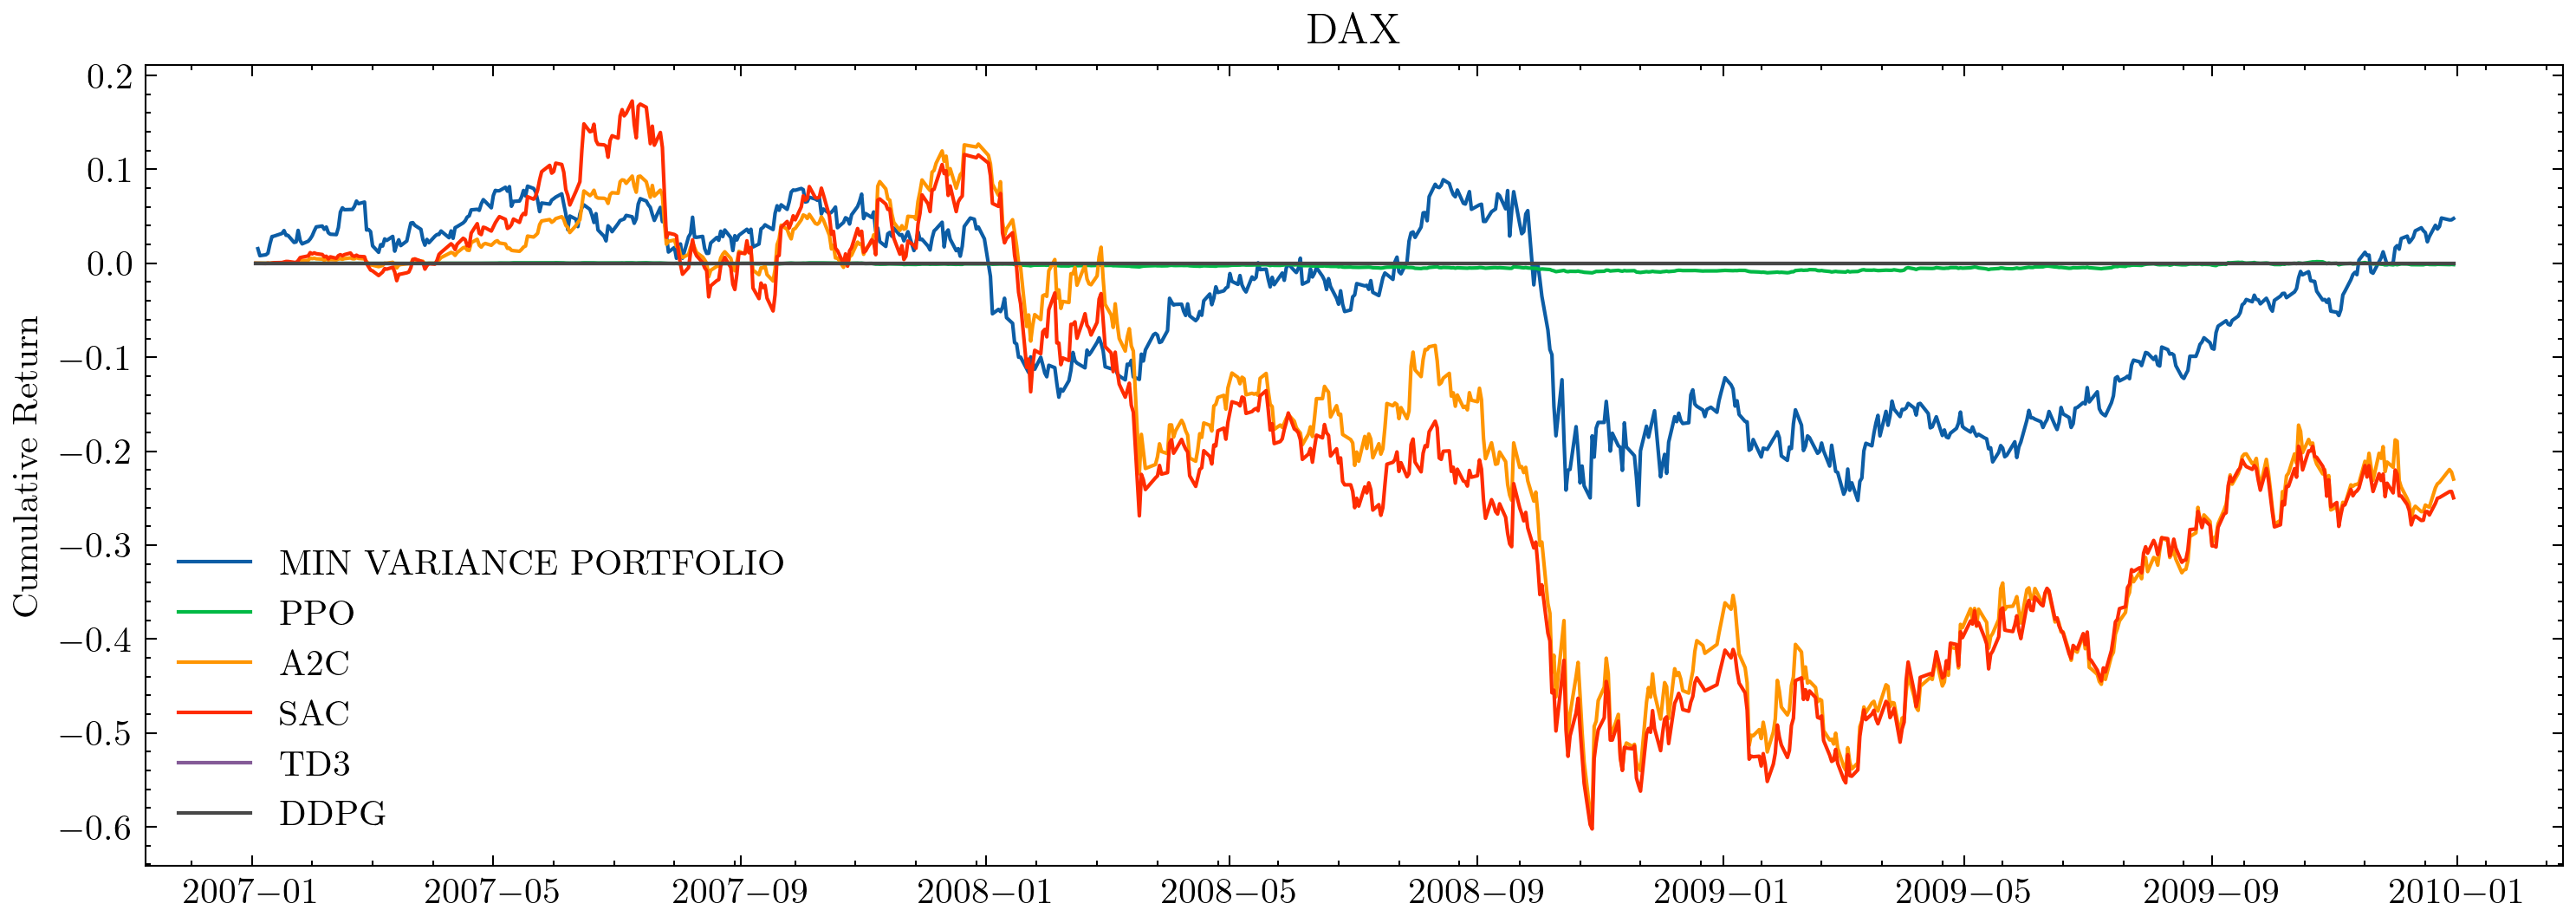

In [36]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(mvo_result):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod() -1,label=str(item['name']).upper())
    plt.plot(ppo_predictions_dax_risk_free['account']['date'],(ppo_predictions_dax_risk_free['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(a2c_predictions_dax_risk_free['account']['date'],(a2c_predictions_dax_risk_free['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='A2C')
    plt.plot(sac_predictions_dax_risk_free['account']['date'],(sac_predictions_dax_risk_free['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(td3_predictions_dax_risk_free['account']['date'],(td3_predictions_dax_risk_free['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='TD3')
    plt.plot(ddpg_predictions_dax_risk_free['account']['date'],(ddpg_predictions_dax_risk_free['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='DDPG')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('DAX')
    plt.show()

## COVID

In [3]:
INDICATORS = [
    "close_5_ema",
    "close_21_ema",
]
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2019-12-30'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2024-12-01'
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed_data = fe.preprocess_data(df_dax.query('date>"2005-01-01"'))
processed_data = processed_data.copy()
processed_data = processed_data.fillna(0)
processed_data = processed_data.replace(np.inf,0)
train_data = data_split(processed_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_data, TEST_START_DATE, TEST_END_DATE)


Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


In [164]:
train_data.tic.unique()

array(['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE',
       'CON.DE', 'DB1.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
       'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LIN.DE', 'MRK.DE',
       'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'VOW3.DE'], dtype=object)

In [18]:
train_data

Unnamed: 0        date        open        high         low       close  \
0          70960  2010-01-04   37.959999   38.525002   37.685001   31.563414   
0          70961  2010-01-04   87.800003   88.889999   87.599998   43.213936   
0          70962  2010-01-04   43.459999   44.849998   43.349998   22.495089   
0          70963  2010-01-04   55.315983   55.808029   54.863300   36.101337   
0          70964  2010-01-04   45.849998   46.619999   45.799999   40.290039   
...          ...         ...         ...         ...         ...         ...   
2534      137670  2019-12-27  268.000000  268.000000  264.899994  216.872223   
2534      137671  2019-12-27   27.070000   27.340000   27.030001   23.243727   
2534      137672  2019-12-27  121.080002  122.040001  120.739998  111.968185   
2534      137673  2019-12-27  105.921509  106.985229  105.705154   91.757790   
2534      137675  2019-12-27  176.880005  177.119995  175.160004  108.352081   

       volume      tic  day  close_5_ema  close_21_ema  turbulence    return  \
0      953276   ADS.DE    0    31.428464     31.107128   13.551298  0.019460   
0     1676777   ALV.DE    0    42.808714     41.887369   13.551298  0.015950   
0     3245626   BAS.DE    0    22.084318     21.493717   13.551298  0.031984   
0     2251520  BAYN.DE    0    35.895730     34.890681   13.551298  0.007863   
0      336203   BEI.DE    0    39.982789     39.424023   13.551298  0.011213   
...       ...      ...  ...          ...           ...         ...       ...   
2534   297805  MUV2.DE    4   217.132273    214.136227    6.249519 -0.004874   
2534  1368804   RWE.DE    4    23.055560     22.767091    6.249519  0.002965   
2534  1164464   SAP.DE    4   111.615684    111.970692    6.249519  0.005300   
2534  1216387   SIE.DE    4    91.483314     90.577127    6.249519  0.006127   
2534   394014  VOW3.DE    4   108.780504    108.919252    6.249519  0.002838   

      log_return  
0       0.019273  
0       0.015824  
0       0.031483  
0       0.007832  
0       0.011150  
...          ...  
2534   -0.004886  
2534    0.002961  
2534    0.005286  
2534    0.006108  
2534    0.002834  

[58305 rows x 14 columns]

In [17]:
len(train_data.tic.unique())

23

In [10]:
from utils import mvo_data
cov_df = mvo_data(processed_data, TEST_START_DATE, TEST_END_DATE)


In [13]:
min_variance_portfolio = mvo(cov_df,pct=0.001)


begin_total_asset:50000
end_total_asset:40866.86400933568
Sharpe:  0.6153962657710532
Test Finished!
episode_return 0.8173372801867136


In [9]:
def plot_weights(s,train_data):
    states = np.array(s)
    states_prices = states[:,1:len(train_data.tic.unique())+1]
    states_shares = states[:,len(train_data.tic.unique())+1 : 2*len(train_data.tic.unique())+1  ]
    holdigns = states_shares* states_prices
    holdings = pd.DataFrame(holdigns,columns=train_data.tic.unique())
    return holdings

### log return

In [16]:
len(train_data.tic.unique())


23

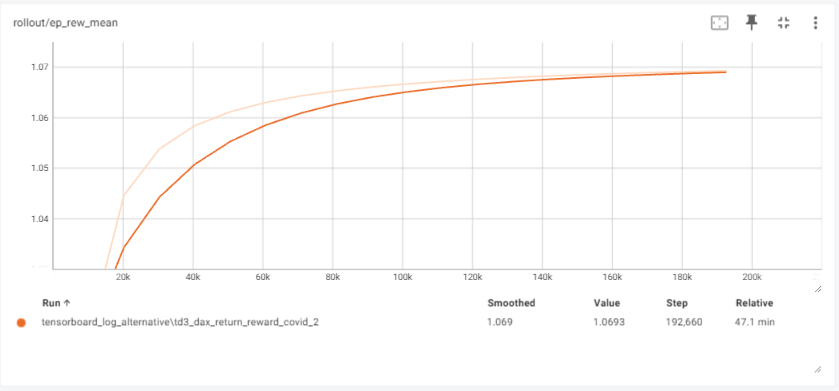
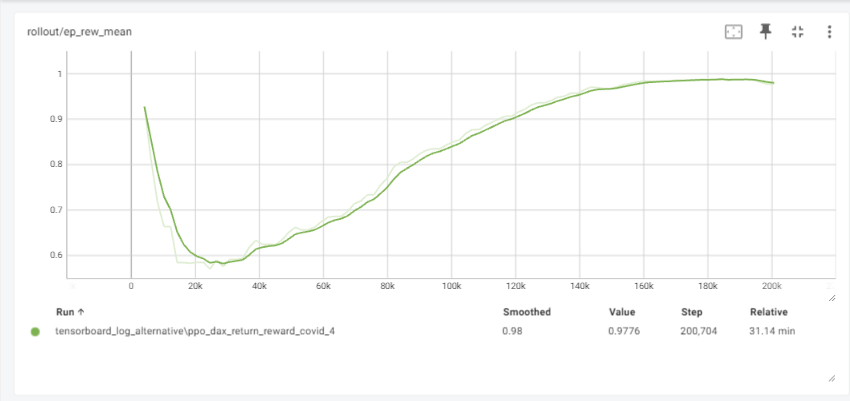
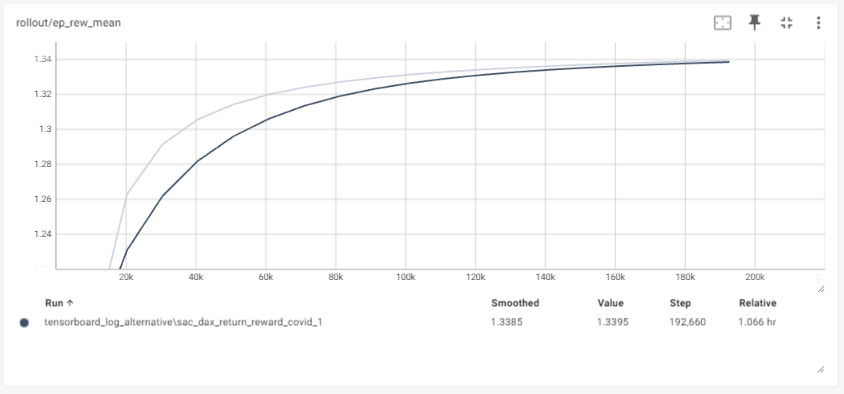

In [ ]:
iterations = 200_000
ppo_predictions_covid = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='dax_return_reward_covid')
td3_predictions_covid = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='dax_return_reward_covid')
sac_predictions_covid = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='dax_return_reward_covid')

Stock Dimension: 23, State Space: 93
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log_alternative/ppo_dax_return_reward_covid_4
------------------------------------
| time/              |             |
|    fps             | 109         |
|    iterations      | 1           |
|    time_elapsed    | 18          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.009420256 |
------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.54e+03    |
|    ep_rew_mean          | 0.928       |
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2           |
|    time_elapsed         | 37          |
|    total_timesteps      | 4096        |
| trai

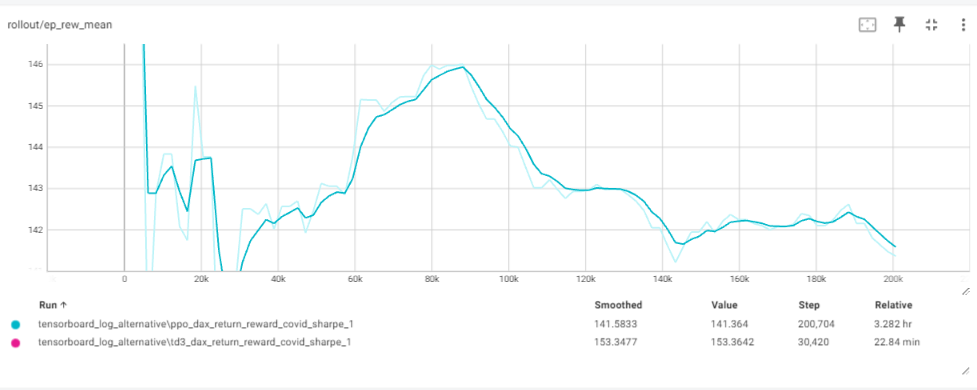

In [ ]:
iterations = 200_000
ppo_predictions_covid_sharpe = train(train_data,test_data,INDICATORS,"ppo",None,iterations,sharpe=True,load_model=False,tag='dax_return_reward_covid_sharpe')
td3_predictions_covid_sharpe = train(train_data,test_data,INDICATORS,"td3",None,iterations,sharpe=True,load_model=False,tag='dax_return_reward_covid_sharpe')
sac_predictions_covid_sharpe = train(train_data,test_data,INDICATORS,"sac",None,iterations,sharpe=True,load_model=False,tag='dax_return_reward_covid_sharpe')

In [10]:
weights_ppo = plot_weights(ppo_predictions_covid['state'],train_data)

In [19]:
ppo_predictions_covid['state']

[[939555.4037174645,
  281.56494140625,
  168.48333740234375,
  48.687950134277344,
  61.82914352416992,
  101.9375457763672,
  53.47330856323242,
  89.23696899414062,
  125.7153778076172,
  6.680480003356934,
  12.729835510253906,
  7.576627731323242,
  58.35820770263672,
  44.85630416870117,
  54.49643707275391,
  80.70429229736328,
  19.46022605895996,
  171.43064880371094,
  100.9387664794922,
  214.58421325683597,
  23.05475616455078,
  111.1012191772461,
  90.29885864257812,
  108.33980560302734,
  14,
  0,
  0,
  20,
  102,
  66,
  90,
  24,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  68,
  0,
  64,
  92,
  52,
  0,
  14,
  0,
  280.65211642309436,
  169.1417396771703,
  48.95581274820239,
  61.96206417661379,
  102.1839981862978,
  53.741426906837866,
  90.40391662672316,
  126.33563661617013,
  6.572550407317884,
  12.75908129775543,
  7.602575584979019,
  58.53278386783527,
  45.011811921614274,
  55.39288320795007,
  81.08842936683673,
  19.52270292617523,
  174.45788484009435,
  9

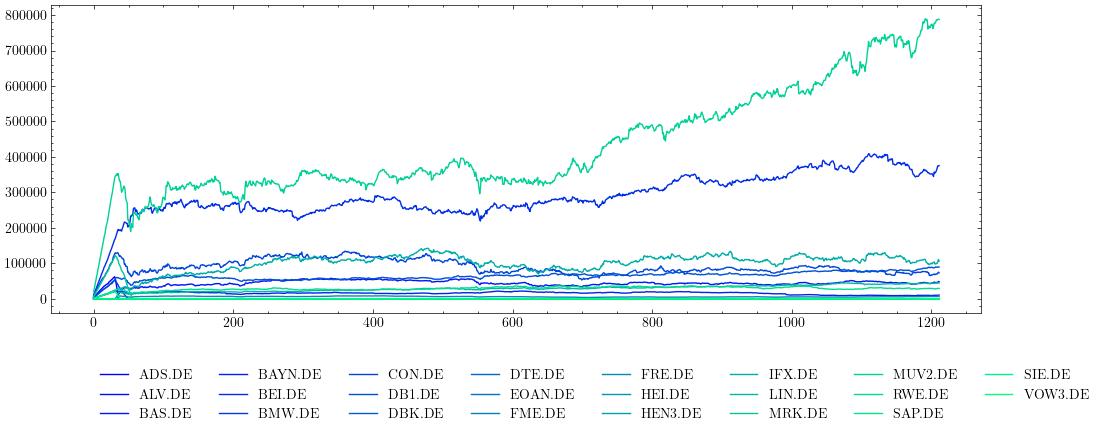

In [11]:
%matplotlib inline
with plt.style.context('science','ieee'):
    weights_ppo.plot(figsize=(12,4),colormap="winter",).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

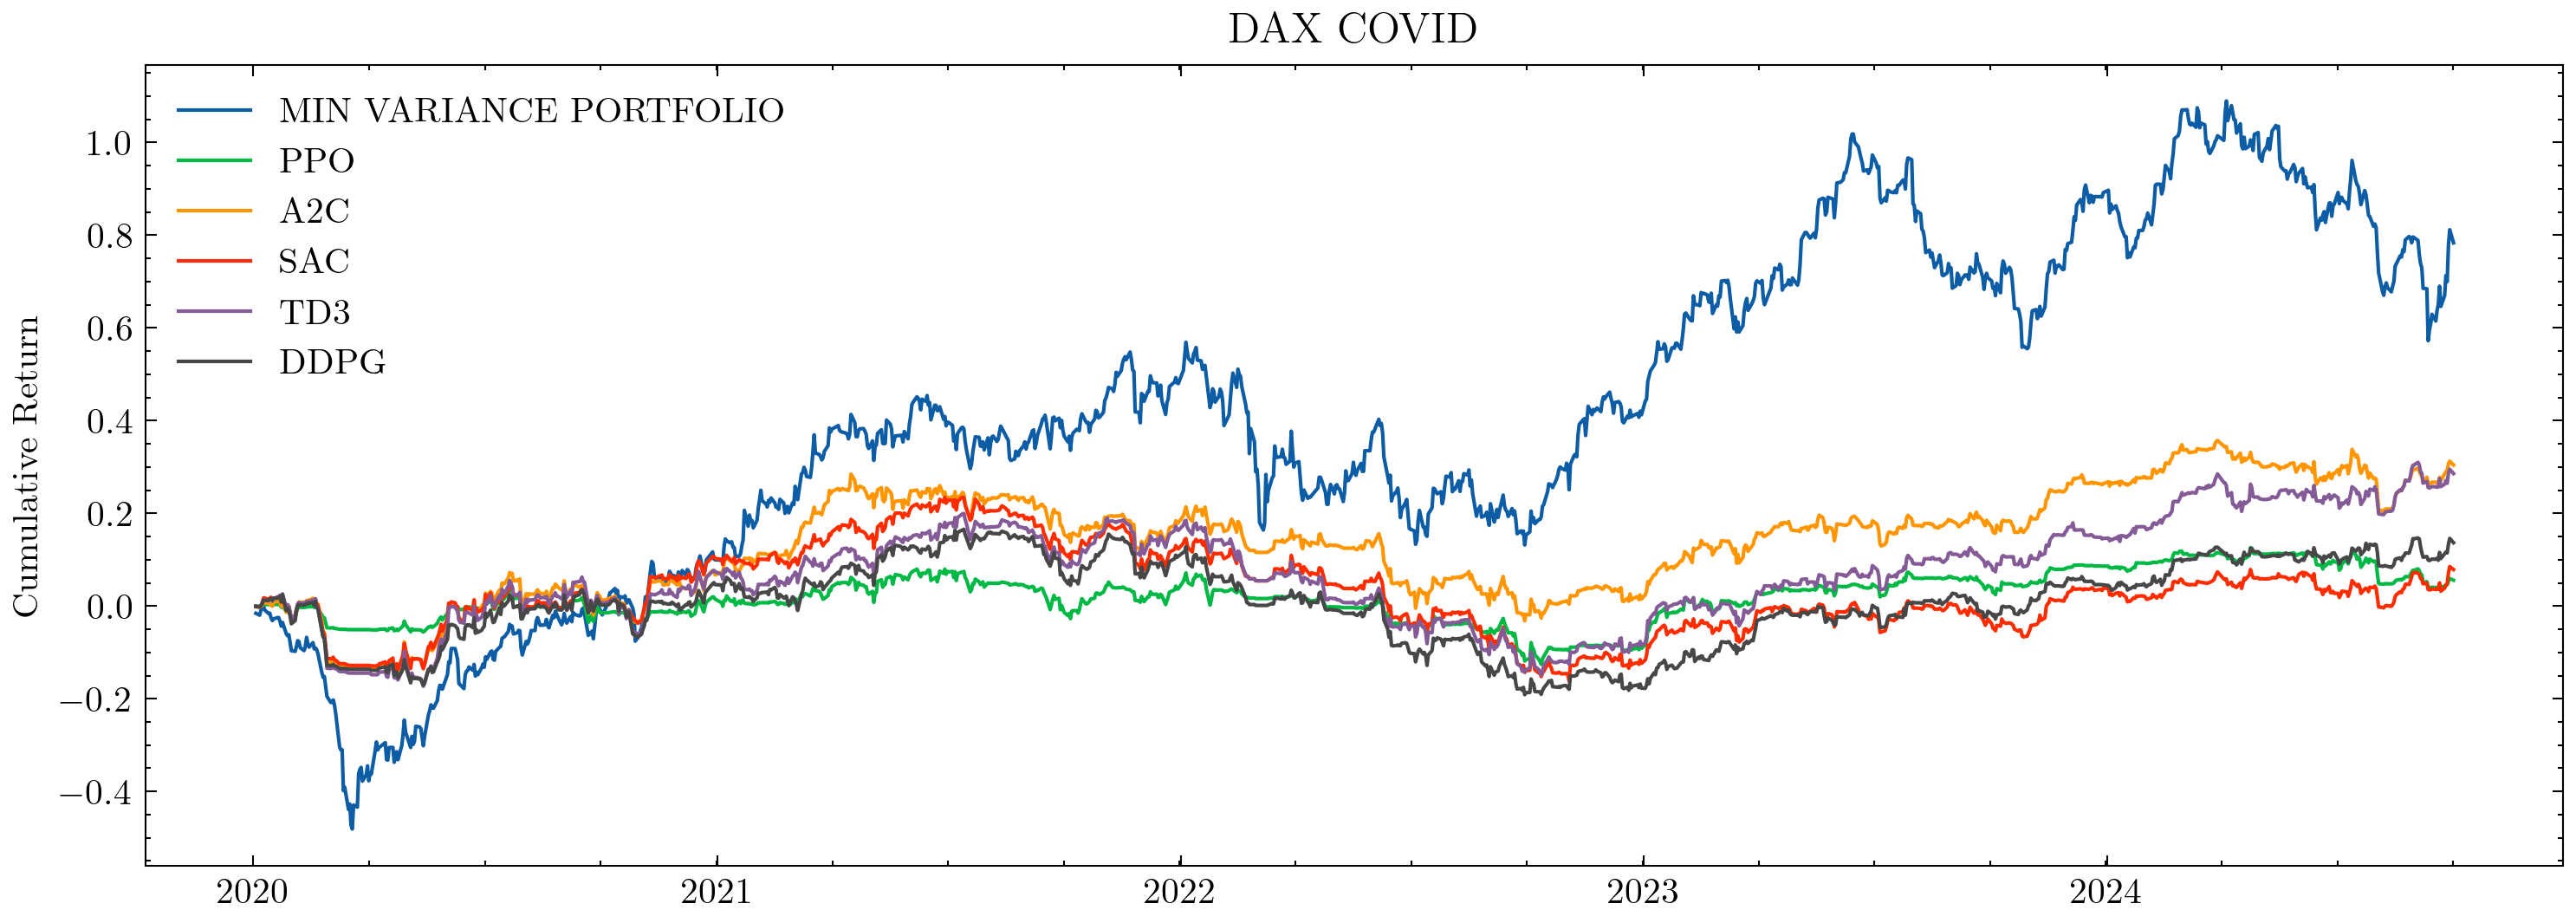

In [166]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(mvo_result):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod() -1,label=str(item['name']).upper())
    plt.plot(ppo_predictions_covid['account']['date'],(ppo_predictions_covid['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(a2c_predictions_covid['account']['date'],(a2c_predictions_covid['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='A2C')
    plt.plot(sac_predictions_covid['account']['date'],(sac_predictions_covid['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(td3_predictions_covid['account']['date'],(td3_predictions_covid['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='TD3')
    plt.plot(ddpg_predictions_covid['account']['date'],(ddpg_predictions_covid['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='DDPG')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('DAX COVID')
    plt.show()

In [171]:
iterations = 60_000
ppo_predictions_covid_no_turbulence = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='dax_covid_no_turbulence',threshold=None)
a2c_predictions_covid_no_turbulence = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='dax_covid_no_turbulence',threshold=None)
td3_predictions_covid_no_turbulence = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='dax_covid_no_turbulence',threshold=None)
sac_predictions_covid_no_turbulence = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='dax_covid_no_turbulence',threshold=None)
ddpg_predictions_covid_no_turbulence = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='dax_covid_no_turbulence',threshold=None)

Stock Dimension: 23, State Space: 70
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/              |             |
|    fps             | 100         |
|    iterations      | 1           |
|    time_elapsed    | 20          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.005461611 |
------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.54e+03    |
|    ep_rew_mean          | 0.921       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.01482

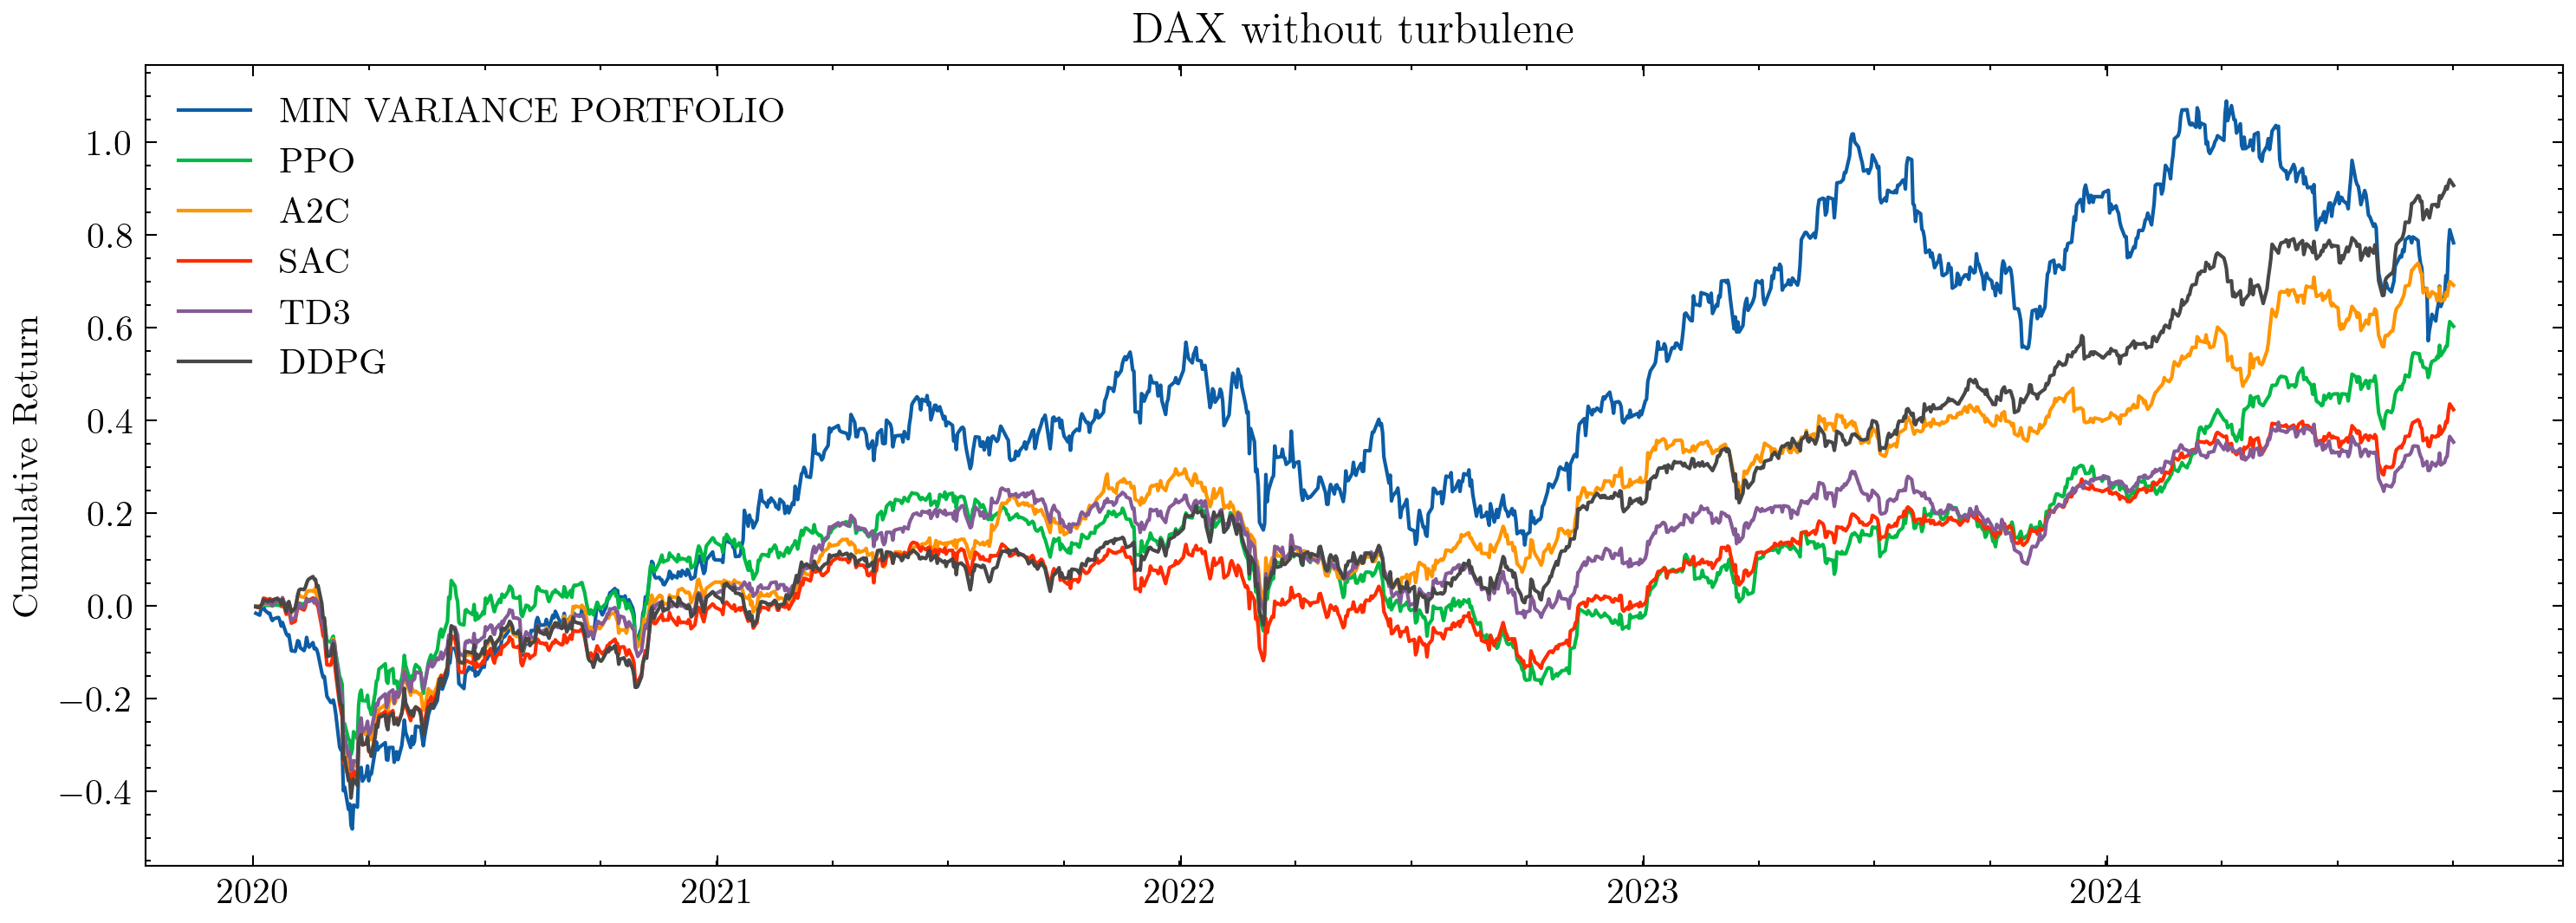

In [173]:
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(mvo_result):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod() -1,label=str(item['name']).upper())
    plt.plot(ppo_predictions_covid_no_turbulence['account']['date'],(ppo_predictions_covid_no_turbulence['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='PPO')
    plt.plot(a2c_predictions_covid_no_turbulence['account']['date'],(a2c_predictions_covid_no_turbulence['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='A2C')
    plt.plot(sac_predictions_covid_no_turbulence['account']['date'],(sac_predictions_covid_no_turbulence['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='SAC')
    plt.plot(td3_predictions_covid_no_turbulence['account']['date'],(td3_predictions_covid_no_turbulence['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='TD3')
    plt.plot(ddpg_predictions_covid_no_turbulence['account']['date'],(ddpg_predictions_covid_no_turbulence['account']['account_value'].pct_change()+ 1 ).cumprod() -1,label='DDPG')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('DAX without turbulene')
    plt.show()

In [72]:
iterations = 60_000
ppo_predictions_covid_pct_fee = train(train_data,test_data,INDICATORS,"ppo",None,iterations,True,load_model=False,tag='dax_covid_pct_fee',pct_fee=0.02)
a2c_predictions_covid_pct_fee = train(train_data,test_data,INDICATORS,"a2c",None,iterations,True,load_model=False,tag='dax_covid_pct_fee',pct_fee=0.02)
td3_predictions_covid_pct_fee = train(train_data,test_data,INDICATORS,"td3",None,iterations,True,load_model=False,tag='dax_covid_pct_fee',pct_fee=0.02)
sac_predictions_covid_pct_fee = train(train_data,test_data,INDICATORS,"sac",None,iterations,True,load_model=False,tag='dax_covid_pct_fee',pct_fee=0.02)
ddpg_predictions_covid_pct_fee = train(train_data,test_data,INDICATORS,"ddpg",None,iterations,True,load_model=False,tag='dax_covid_pct_fee',pct_fee=0.02)

Stock Dimension: 2, State Space: 7
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--------------------------------------
| time/              |               |
|    fps             | 227           |
|    iterations      | 1             |
|    time_elapsed    | 9             |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | 0.00020848085 |
--------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.54e+03      |
|    ep_rew_mean          | -0.188        |
| time/                   |               |
|    fps                  | 220           |
|    iterations           | 2             |
|    time_elapsed         | 18            |
|    total_timesteps      | 4096          |
| train/                  |               |